In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [8]:
import missingno as msno

# 经验分布函数
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso,LassoCV
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestRegressor

seed = 123

In [11]:
data = pd.read_csv('data/Auto-Data.csv', na_values='?')
data.head(5)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


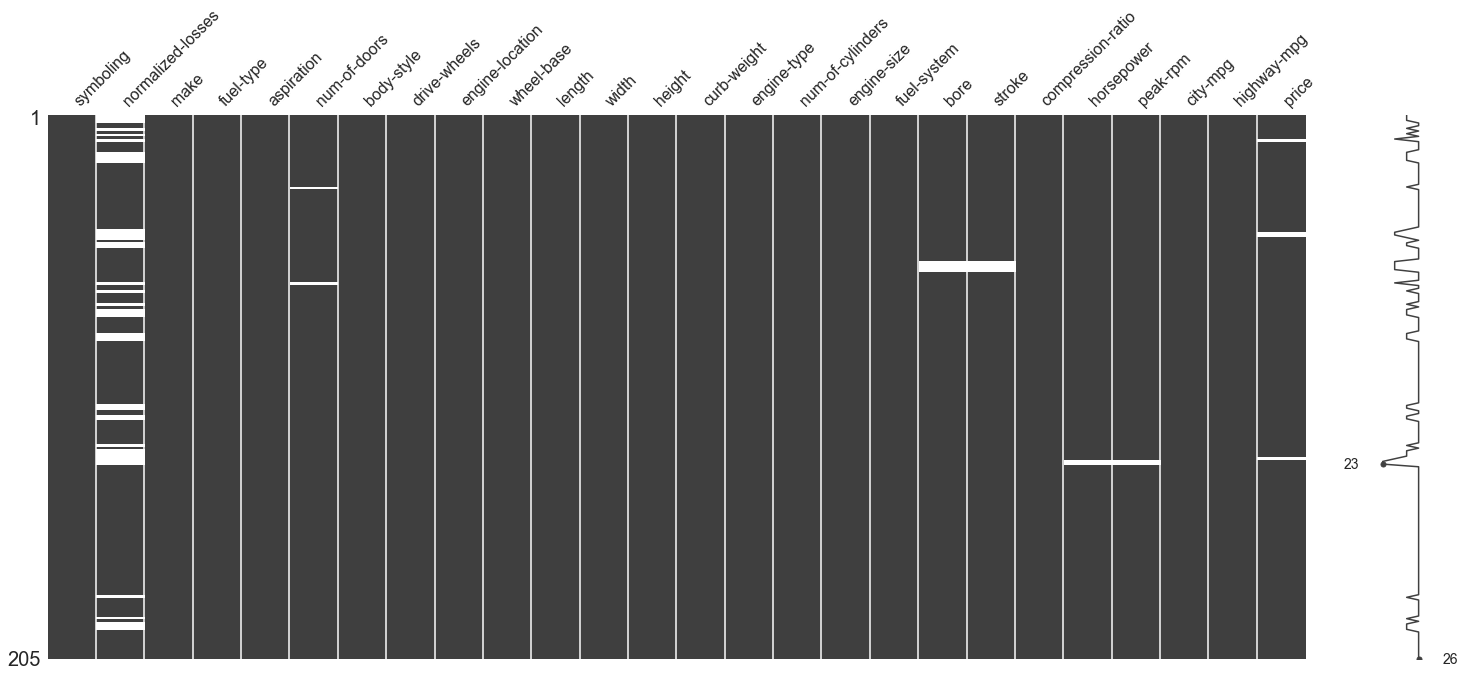

In [16]:
sns.set_style('ticks')
msno.matrix(data)

(array([12., 23., 34., 20., 16., 12., 18., 18.,  1.,  8.,  0.,  0.,  1.,
         1.]), array([ 65.        ,  78.64285714,  92.28571429, 105.92857143,
        119.57142857, 133.21428571, 146.85714286, 160.5       ,
        174.14285714, 187.78571429, 201.42857143, 215.07142857,
        228.71428571, 242.35714286, 256.        ]), <a list of 14 Patch objects>)

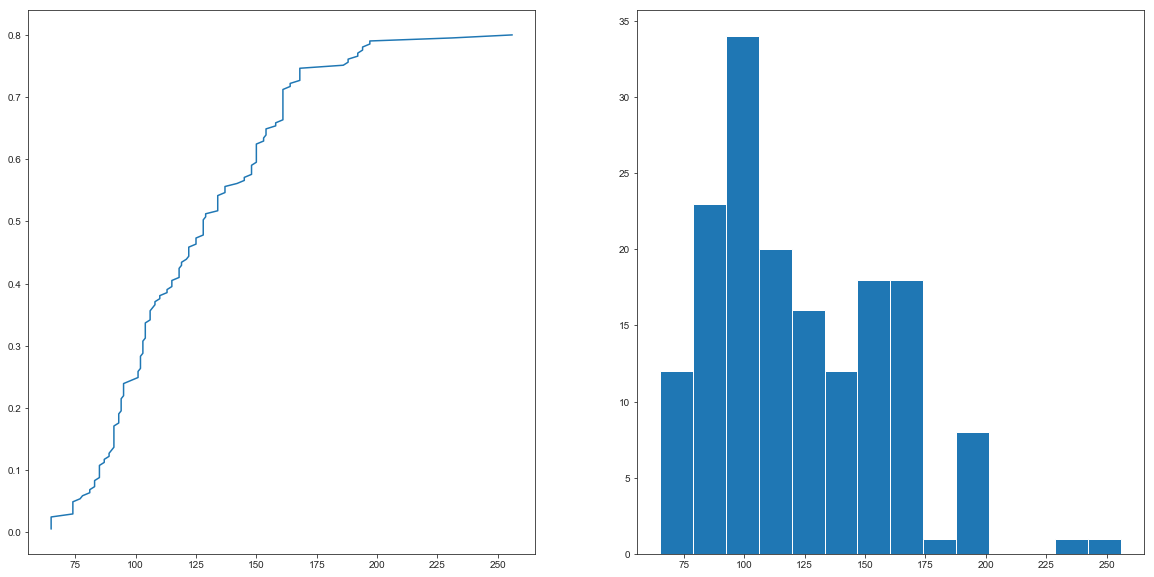

In [27]:
cdf = ECDF(data['normalized-losses'])
fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot(121)
ax1.plot(cdf.x, cdf.y, label='statsmodel')
ax2 = plt.subplot(122)
ax2.hist(data['normalized-losses'], bins=int(np.sqrt(len(data['normalized-losses']))))

In [32]:
data = data.dropna(subset=['num-of-doors','bore','stroke','horsepower','peak-rpm','price'])
data['normalized-losses'] = data.groupby('symboling')['normalized-losses'].transform(lambda x: x.fillna(x.mean()))

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


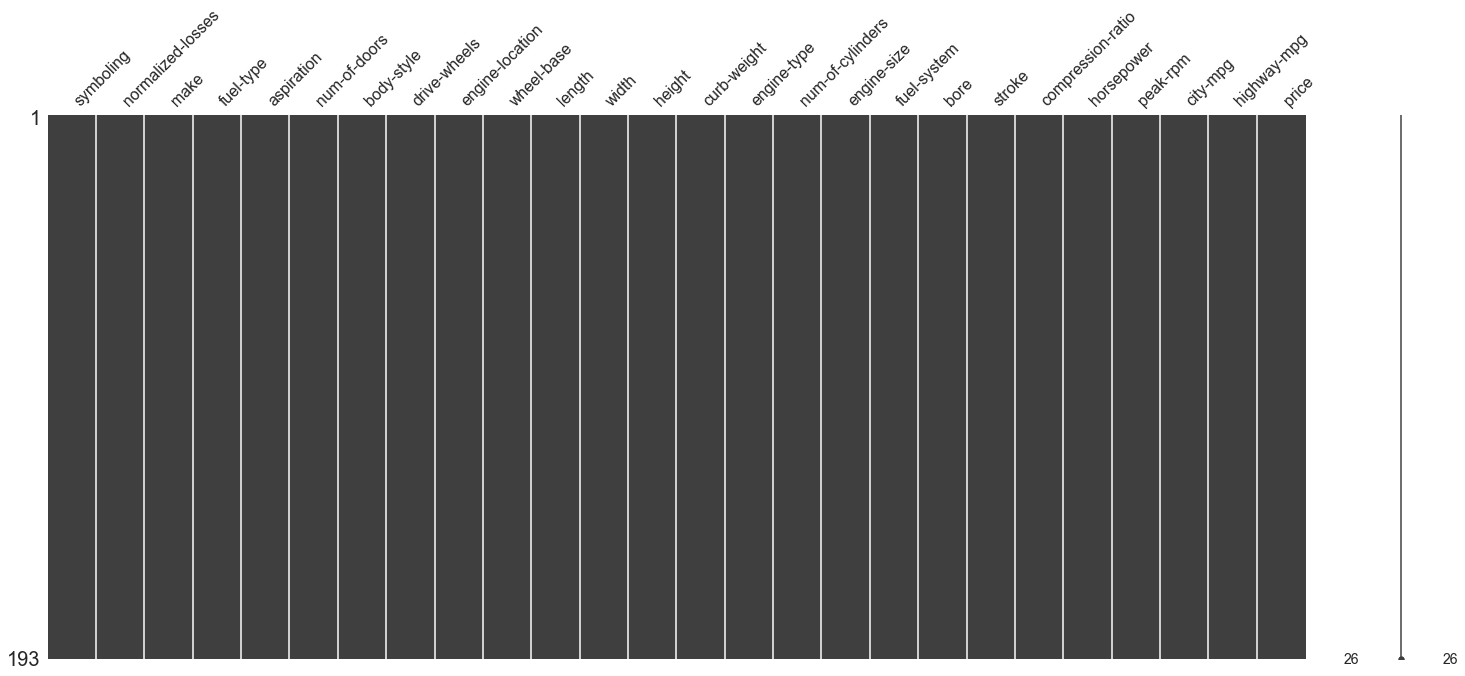

In [34]:
msno.matrix(data)

In [39]:
'''
特征相关性
'''

'\n特征相关性\n'

In [95]:
cormatrix = data.corr()
cormatrix *= np.tri(*cormatrix.values.shape,k=-1).T

In [96]:
cormatrix = cormatrix.stack()
cormatrix = cormatrix.reindex(cormatrix.abs().sort_values(ascending=False).index).reset_index()

In [105]:
data['volumn'] = data.length * data.width * data.height
data.drop(columns=['length','height','width'], axis=1,inplace=True)

AttributeError: 'DataFrame' object has no attribute 'length'

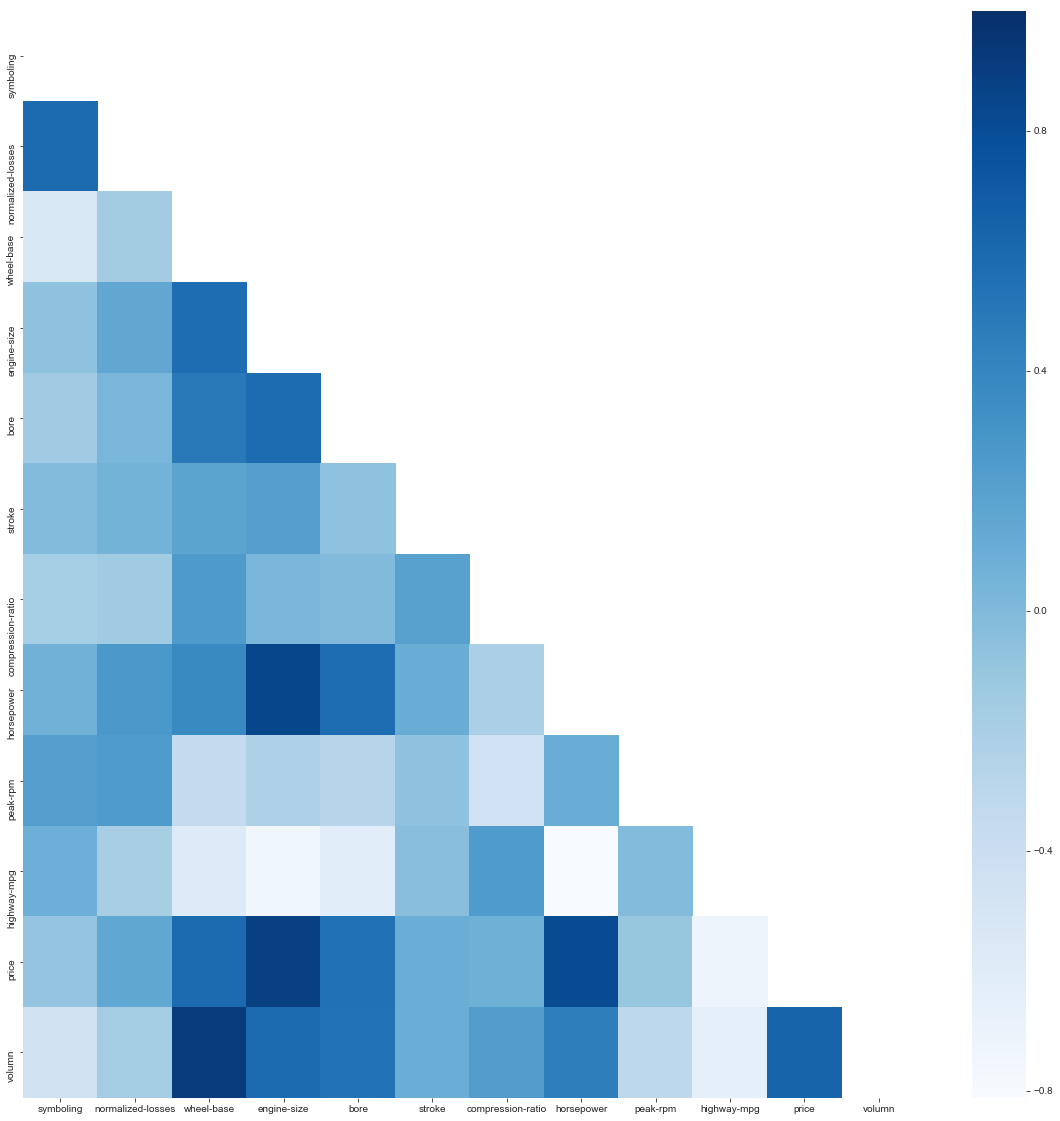

In [116]:
corr_aft = data.corr()
mask = np.zeros_like(corr_aft, dtype=bool)
mask[np.triu_indices_from(mask)] = True

fig,ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr_aft, mask=mask,cmap='Blues')

In [130]:
y = data['price']
features_tags = [x for x in data.columns if x != 'price']
features = data.loc[:,features_tags]

numeric_tags = ['symboling',
 'normalized-losses',
 'wheel-base',
 'bore',
 'stroke',
 'compression-ratio',
 'horsepower',
 'peak-rpm',
 'volumn']

stand_scaler = StandardScaler()
features[numeric_tags] = stand_scaler.fit_transform(features[numeric_tags])
features[numeric_tags]

d:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
d:\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,symboling,normalized-losses,wheel-base,bore,stroke,compression-ratio,horsepower,peak-rpm,volumn
0,1.786850,1.336575,-1.682379,0.513027,-1.808186,-0.288273,0.198569,-0.213359,-1.168294
1,1.786850,1.336575,-1.682379,0.513027,-1.808186,-0.288273,0.198569,-0.213359,-1.168294
2,0.163970,0.167150,-0.720911,-2.394827,0.702918,-0.288273,1.334283,-0.213359,-0.422041
3,0.975410,1.200962,0.142781,-0.517605,0.480415,-0.036204,-0.039139,0.856208,0.169527
4,0.975410,1.200962,0.077596,-0.517605,0.480415,-0.540341,0.304217,0.856208,0.193551
5,0.975410,0.082964,0.142781,-0.517605,0.480415,-0.414307,0.172157,0.856208,0.036405
6,0.163970,1.025866,1.120545,-0.517605,0.480415,-0.414307,0.172157,0.856208,1.817385
7,0.163970,0.167150,1.120545,-0.517605,0.480415,-0.414307,0.172157,0.856208,1.817385
8,0.163970,1.025866,1.120545,-0.738454,0.480415,-0.464721,0.964515,0.856208,1.851856
10,0.975410,2.018076,0.370926,0.623452,-1.426752,-0.338686,-0.065551,1.497949,0.010169


In [142]:
verb_tags = ['make',
 'fuel-type',
 'aspiration',
 'num-of-doors',
 'body-style',
 'drive-wheels',
 'engine-location',
 'engine-type',
 'num-of-cylinders',
 'fuel-system']

dummies = pd.get_dummies(features[verb_tags])
features = features.join(dummies).drop(verb_tags,axis=1)

KeyError: "['make' 'fuel-type' 'aspiration' 'num-of-doors' 'body-style'\n 'drive-wheels' 'engine-location' 'engine-type' 'num-of-cylinders'\n 'fuel-system'] not in index"

In [143]:
features

,symboling,normalized-losses,wheel-base,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,highway-mpg,...,num-of-cylinders_six,num-of-cylinders_three,num-of-cylinders_twelve,fuel-system_1bbl,fuel-system_2bbl,fuel-system_idi,fuel-system_mfi,fuel-system_mpfi,fuel-system_spdi,fuel-system_spfi
0,1.786850,1.336575,-1.682379,130,0.513027,-1.808186,-0.288273,0.198569,-0.213359,27,...,0,0,0,0,0,0,0,1,0,0
1,1.786850,1.336575,-1.682379,130,0.513027,-1.808186,-0.288273,0.198569,-0.213359,27,...,0,0,0,0,0,0,0,1,0,0
2,0.163970,0.167150,-0.720911,152,-2.394827,0.702918,-0.288273,1.334283,-0.213359,26,...,1,0,0,0,0,0,0,1,0,0
3,0.975410,1.200962,0.142781,109,-0.517605,0.480415,-0.036204,-0.039139,0.856208,30,...,0,0,0,0,0,0,0,1,0,0
4,0.975410,1.200962,0.077596,136,-0.517605,0.480415,-0.540341,0.304217,0.856208,22,...,0,0,0,0,0,0,0,1,0,0
5,0.975410,0.082964,0.142781,136,-0.517605,0.480415,-0.414307,0.172157,0.856208,25,...,0,0,0,0,0,0,0,1,0,0
6,0.163970,1.025866,1.120545,136,-0.517605,0.480415,-0.414307,0.172157,0.856208,25,...,0,0,0,0,0,0,0,1,0,0
7,0.163970,0.167150,1.120545,136,-0.517605,0.480415,-0.414307,0.172157,0.856208,25,...,0,0,0,0,0,0,0,1,0,0
8,0.163970,1.025866,1.120545,131,-0.738454,0.480415,-0.464721,0.964515,0.856208,20,...,0,0,0,0,0,0,0,1,0,0
10,0.975410,2.018076,0.370926,108,0.623452,-1.426752,-0.338686,-0.065551,1.497949,29,...,0,0,0,0,0,0,0,1,0,0


In [145]:
X_train,X_test,y_train,y_test = train_test_split(features,y,random_state=seed,test_size=0.3)

In [206]:
alphas = 2. ** np.arange(2,12)
scores = np.empty_like(alphas)

for i,a in enumerate(alphas):
    lasso = Lasso(random_state=seed)
    lasso.set_params(alpha=a)
    mod = lasso.fit(X_train, y_train)
    scores[i] = lasso.score(X_test,y_test)
    
lassocv = LassoCV(cv=10, random_state=seed)
mod = lassocv.fit(features,y)
lassocv_score = lassocv.score(features,y)
alphas_cv = lassocv.alpha_

result = mod.predict(np.array(features.loc[:0]))
print('pred: {} - source: {} '.format(result, y.loc[0]))

pred: [13550.26795372] - source: 13495.0 


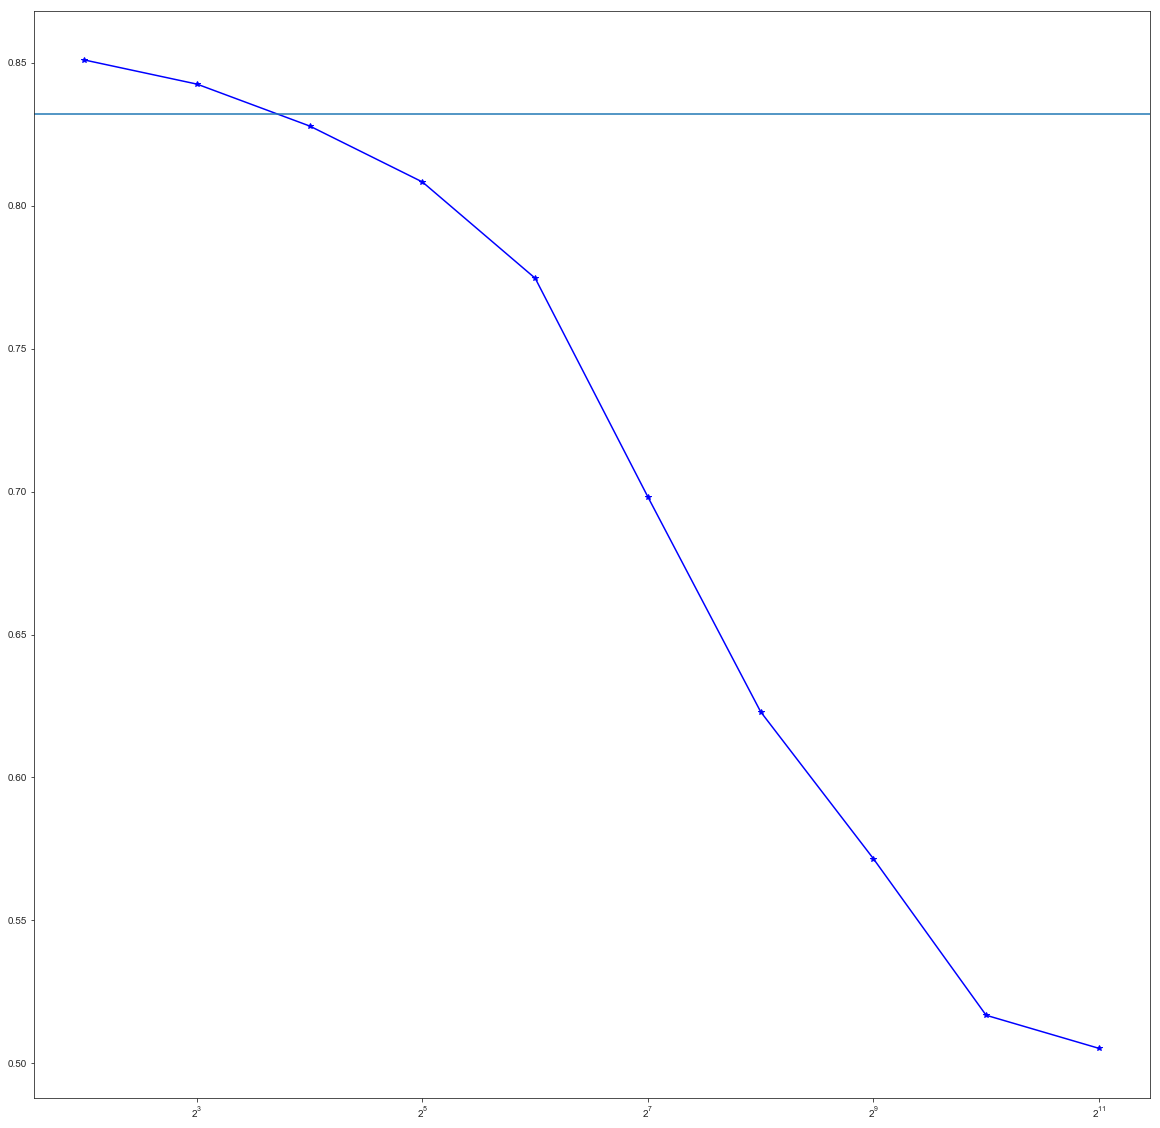

In [175]:
fig = plt.figure(figsize=(20,20))
plt.plot(alphas, scores, 'b-*')

plt.axhline(lassocv_score)
plt.xscale('log',basex=2)